# Transfer Learning - Fine Tuning

In [1]:
# Importing TF and checking the version
import tensorflow as tf

print(tf.__version__)

2.10.1


In [2]:
# Importing Daniel Bourke's helper functions
from DanielBourke_HelperFunctions import create_tensorboard_callback, plot_loss_curves, walk_through_dir

In [3]:
# Check how many images are in target folders
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
# Creating training and test dir paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [5]:
# Creating image dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
# Check train dataset
train_data_10percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
# Check class names
train_data_10percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
# Getting sample batch data
for images, labels in train_data_10percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[178.        172.        158.       ]
   [178.        172.        158.       ]
   [178.        172.        158.       ]
   ...
   [  2.          4.          1.       ]
   [  2.          4.          1.       ]
   [  3.          5.          2.       ]]

  [[178.        172.        156.       ]
   [178.        172.        156.       ]
   [178.        172.        156.       ]
   ...
   [  2.          4.          1.       ]
   [  2.9336746   4.933675    1.9336746]
   [  3.          5.          2.       ]]

  [[178.        172.        156.       ]
   [178.        172.        156.       ]
   [178.        172.        156.       ]
   ...
   [  3.          5.          2.       ]
   [  3.0153089   5.015309    2.0153089]
   [  4.          6.          3.       ]]

  ...

  [[218.64285   207.64285   189.64285  ]
   [217.14285   206.14285   187.71432  ]
   [220.42854   209.42854   190.66328  ]
   ...
   [165.26018   140.97429   114.61707  ]
   [154.98457   121.99994    91.811134 ]
   [1

## Creating Transfer Learning models with Keras' Functional API

### Model 0

In [9]:
# Creating baseline model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freezing the model to avoid changes to pre-trained patterns
base_model.trainable = False

# Creating inputs into the model
inputs = tf.keras.layers.Input(
    shape=(224, 224, 3),
    name="input_layer"
)

# If using ResNet50V2 (not EfficientNetB0), then input needs to be re-scaled
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# Passing the inputs to baseline model
x = base_model(inputs)
print(f"Shape after passing the inputs: {x.shape}.")

# Average pooling the outputs
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalPooling2D: {x.shape}.")

# Creating outputs of the model
outputs = tf.keras.layers.Dense(
    10,
    activation="softmax",
    name="output_layer"
)(x)

# Combining inputs and outputs to set a model
model_0 = tf.keras.Model(inputs, outputs)

Shape after passing the inputs: (None, 7, 7, 1280).
Shape after GlobalPooling2D: (None, 1280).


In [12]:
# Compiling the model
model_0.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fitting the model
history_0 = model_0.fit(
    train_data_10percent,
    epochs=5,
    steps_per_epoch=len(train_data_10percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent")]
)

Saving TensorBoard log files to: transfer_learning/10_percent/20221210-181733
Epoch 1/5
24/24 [==============================] - 56s 2s/step - loss: 0.4907 - accuracy: 0.8800 - val_loss: 0.4703 - val_accuracy: 0.8766
Epoch 2/5
24/24 [==============================] - 58s 2s/step - loss: 0.4006 - accuracy: 0.9120 - val_loss: 0.4501 - val_accuracy: 0.8717
Epoch 3/5
24/24 [==============================] - 57s 2s/step - loss: 0.3401 - accuracy: 0.9280 - val_loss: 0.4427 - val_accuracy: 0.8783
Epoch 4/5
24/24 [==============================] - 56s 2s/step - loss: 0.3031 - accuracy: 0.9453 - val_loss: 0.4291 - val_accuracy: 0.8750
Epoch 5/5
24/24 [==============================] - 50s 2s/step - loss: 0.2669 - accuracy: 0.9507 - val_loss: 0.4140 - val_accuracy: 0.8816


In [13]:
# Evaluate against the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 162s 2s/step - loss: 0.4166 - accuracy: 0.8752


[0.41661161184310913, 0.8751999735832214]

In [14]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [15]:
# Getting summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
# Getting summary of the whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


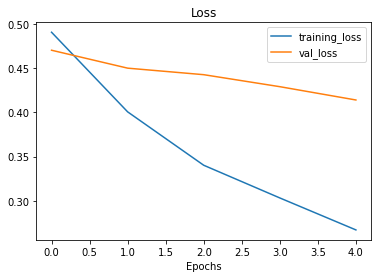

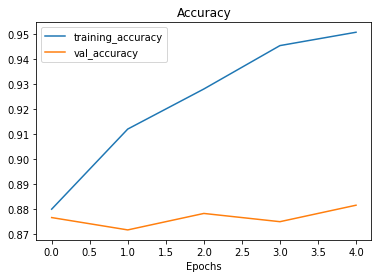

In [17]:
# Visualising the loss curves
plot_loss_curves(history_0)

### Underrstanfding Average Pooling 2D

In [18]:
# Defining input shape
input_shape =(1, 4, 4, 3) 

# Creating a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.26454744]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.891714  , -0.9384712 ]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728497,  0.40125778, -1.4145442 ],
         [-0.59318566, -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.2347968 , -0.56668764],
         [-0.35819843,  0.88698626,  0.5274477 ]]]], dtype=float32)>